In [1]:
import numpy as np
import pandas as pd
import pickle


from matplotlib import pyplot as plt
%matplotlib inline 

from utils.train_conformal import train_conformal_forecaster

## Data processing

Energy data
* Predicting the `Appliances` variable
* Splitting the sequence with $T=600$ (10 hours) and $H=120$ (2 hours)
* Best is maybe 3826 sequences with stride 5
* Split: 500 test, 2000 train 1330 calibration sequences; the test subsequences are the last ones of the full series

Stock data
* Predicting the `Close` price of ?? stock
* Splitting at higher granularity: $T=30$ and $H=10$ (month and 10 days)
* With offset=1, results in 3655 sequences; 500 for testing, 2000 train and 1155 calibration

Hungarian chickenpox data
* Predicting the weekly number of cases
* Train on most regions and choose other regions for testing (this can fail because different regions can follow different distributions)
* Choose $T=8$, $H=4$ (given past two months, what is the forecast for the next month)

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
from utils.uci_data_processing import prepare_uci_datasets

In [9]:
prepare_uci_datasets()

Dataset: energy, calibrated: True
Dataset: energy, calibrated: False
Dataset: stock, calibrated: True
Dataset: stock, calibrated: False
Dataset: hungary, calibrated: True
Dataset: hungary, calibrated: False


In [4]:
from utils.uci_data_processing import run_uci_experiments
run_uci_experiments(datasets=['stock', 'hungary'], baselines=['DPRNN', 'QRNN'], retrain=True)

CoRNN, energy
Epoch: 0	Train loss: 0.9543098343743218
Epoch: 50	Train loss: 0.8053839339150323
Epoch: 100	Train loss: 0.7272383747277437
Epoch: 150	Train loss: 0.6945838530858358
Epoch: 200	Train loss: 0.6619344287448459
Epoch: 250	Train loss: 0.6518976666309215
Epoch: 300	Train loss: 0.6175822372789737
Epoch: 350	Train loss: 0.8446931618231314
Epoch: 400	Train loss: 0.7859346270561218
Epoch: 450	Train loss: 0.7374632314399436


KeyboardInterrupt: 

In [9]:
calibrate=True
length, stride, horizon = None, None, None
return_raw = not calibrate

In [10]:
df = pd.read_csv('data/hungary_chickenpox/hungary_chickenpox.csv')
length = 8 if length is None else length
stride = 1 if stride is None else stride
horizon = 4 if horizon is None else horizon

if calibrate:
    train_features = ['BUDAPEST', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD',
                      'HAJDU', 'HEVES', 'JASZ',
                      'NOGRAD', 'PEST', 'SZABOLCS']
    cal_features = ['KOMAROM', 'GYOR', 'VESZPREM', 'TOLNA', 'FEJER']
else:
    train_features = ['BUDAPEST', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD',
                      'HAJDU', 'HEVES', 'JASZ',
                      'NOGRAD', 'PEST', 'SZABOLCS', 'KOMAROM', 'GYOR',
                      'VESZPREM', 'TOLNA', 'FEJER']
    cal_features = []
test_features = ['BARANYA', 'SOMOGY', 'ZALA', 'VAS']

train_df = df[train_features]
cal_df = df[cal_features]
test_df = df[test_features]

train_mean = train_df.mean().mean()
train_std = train_df.std().mean()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
cal_df = (cal_df - train_mean) / train_std

return_tensors = not return_raw
train_windows = get_multi_feature_windows(train_df, length,
                                          stride, horizon,
                                          return_tensors=return_tensors)
cal_windows = get_multi_feature_windows(cal_df, length,
                                        stride, horizon,
                                        return_tensors=return_tensors)
test_windows = get_multi_feature_windows(test_df, length,
                                         stride, horizon,
                                         return_tensors=return_tensors)

In [10]:
from utils.uci_data_processing import run_uci_experiments
baselines = run_uci_experiments(baselines=['CoRNN'], retrain=True)

CoRNN, energy
Epoch: 0	Train loss: 0.8498692044189998
Epoch: 50	Train loss: 0.6877447824393
CoRNN, stock
Epoch: 0	Train loss: 0.4199310986754986
Epoch: 50	Train loss: 0.009725503910046358
Epoch: 100	Train loss: 0.009401389863342047
Epoch: 150	Train loss: 0.008964754175394773
Epoch: 200	Train loss: 0.009064613984754452
Epoch: 250	Train loss: 0.007882687531841489
Epoch: 300	Train loss: 0.00751987722917245
Epoch: 350	Train loss: 0.007429347212354724
Epoch: 400	Train loss: 0.007134877807962207
Epoch: 450	Train loss: 0.005933502241252706
Epoch: 500	Train loss: 0.0059755181428045034
Epoch: 550	Train loss: 0.005341269272881059
Epoch: 600	Train loss: 0.004411301190535037
Epoch: 650	Train loss: 0.0039007224841043353
Epoch: 700	Train loss: 0.003460587915749504
Epoch: 750	Train loss: 0.003404118622151705
Epoch: 800	Train loss: 0.003060321807144926
Epoch: 850	Train loss: 0.0028698559438523194
Epoch: 900	Train loss: 0.002999805066233071
Epoch: 950	Train loss: 0.002696756121272651
CoRNN, hungary
Epo

{'CoRNN': {'energy': {'coverages': tensor([[ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [False],
           [False],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [False],
           [False],
           [False],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
           [ True],
        

In [11]:
baseline_results = _

In [12]:
stock_results = baseline_results['CoRNN']['stock']

In [14]:
stock_results['mean_coverage']

0.0

In [17]:
def plot_ts(dataset, coverages, intervals, idx=None, forecast_only=False):
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 8), sharex=True)
    
    if idx is None:
        idx = range(len(dataset))

    for ax in axs.flat:
        i = np.random.choice(idx)
        
        # Derive unpadded sequences and targets
        sequence, target, length = dataset[i]
        
        horizon = min(len(target), length)
        sequence, target = sequence[:length].flatten().tolist(), target[:horizon].flatten().tolist()
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        lower = [sequence[-1]] + intervals[i, 0].flatten().tolist()[:horizon]
        upper = [sequence[-1]] + intervals[i, 1].flatten().tolist()[:horizon]
        pred = [sequence[-1]] + (intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist()[:horizon]
        
        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), pred, linestyle="--", linewidth=3, color="r")

        ax.set(ylabel='Prediction')
    
    plt.xlabel('Time step')
    #     plt.ylabel('Prediction')
    plt.show()

In [30]:
import pickle
with open('data/energy_calibrated_default_test.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

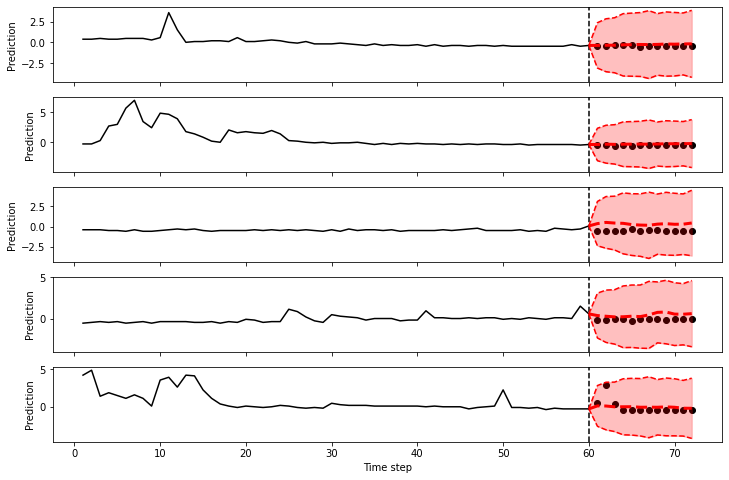

In [31]:
plot_ts(test_dataset, energy_results['coverages'], energy_results['intervals'])

In [36]:
energy_results = baseline_results['CoRNN']['energy']

In [17]:
from utils.uci_data_processing import run_uci_experiments
baselines = run_uci_experiments(baselines=['QRNN', 'DPRNN'], retrain=True)

QRNN, energy
Epoch:  0 | train loss: 0.4792
Epoch:  0 | train loss: 0.1978
Epoch:  0 | train loss: 0.1704
Epoch:  0 | train loss: 0.2196
Epoch:  0 | train loss: 0.1953
Epoch:  0 | train loss: 0.1864
Epoch:  0 | train loss: 0.1425
Epoch:  0 | train loss: 0.1838
Epoch:  0 | train loss: 0.1951
Epoch:  0 | train loss: 0.1824
Epoch:  1 | train loss: 0.1911
Epoch:  1 | train loss: 0.1539
Epoch:  1 | train loss: 0.1392
Epoch:  1 | train loss: 0.1810
Epoch:  1 | train loss: 0.1131
Epoch:  1 | train loss: 0.1567
Epoch:  1 | train loss: 0.2113
Epoch:  1 | train loss: 0.1564
Epoch:  1 | train loss: 0.1412
Epoch:  1 | train loss: 0.1429
Epoch:  2 | train loss: 0.1540
Epoch:  2 | train loss: 0.1228
Epoch:  2 | train loss: 0.1545
Epoch:  2 | train loss: 0.1430
Epoch:  2 | train loss: 0.1550
Epoch:  2 | train loss: 0.1426
Epoch:  2 | train loss: 0.1357
Epoch:  2 | train loss: 0.1253
Epoch:  2 | train loss: 0.1589
Epoch:  2 | train loss: 0.1232
Epoch:  3 | train loss: 0.1468
Epoch:  3 | train loss: 0.

In [24]:
baselines['QRNN']['stock']['Coverage']

0.11094224924012158

In [25]:
baselines = run_uci_experiments(baselines=['CoRNN'], retrain=True)

CoRNN, energy
Epoch: 0	Train loss: 0.8697029607636588
Epoch: 50	Train loss: 0.6368449819939477
CoRNN, stock
Epoch: 0	Train loss: 0.37644054353810275
Epoch: 50	Train loss: 0.009363923275556702
Epoch: 100	Train loss: 0.009251735370176343
Epoch: 150	Train loss: 0.009572926729630966
Epoch: 200	Train loss: 0.008958990990112606
Epoch: 250	Train loss: 0.008904882867892202
Epoch: 300	Train loss: 0.008268369039377341
Epoch: 350	Train loss: 0.007123317014282713
Epoch: 400	Train loss: 0.006455318250048619
Epoch: 450	Train loss: 0.005237145027002463
Epoch: 500	Train loss: 0.005412258315258301
Epoch: 550	Train loss: 0.004580313035358603
Epoch: 600	Train loss: 0.0037649451898267637
Epoch: 650	Train loss: 0.004002160321061428
Epoch: 700	Train loss: 0.004093537913062251
Epoch: 750	Train loss: 0.003024599040285326
Epoch: 800	Train loss: 0.004942499047431808
Epoch: 850	Train loss: 0.002913092585423818
Epoch: 900	Train loss: 0.002873100882145361
Epoch: 950	Train loss: 0.0026468559920501252
CoRNN, hungary

In [28]:
baselines['CoRNN']['hungary']['mean_coverage']

0.9367647171020508